# Algorithme k-means et k-medoids 
## Sur des données de test  
----

# To do :  
- ~~Algorithme KMeans~~
- ~~Ajouter distance L1 et distance cosinus~~
- Comparer KMeans avec le code de l'algorithme de sklearn ==> difficile à comprendre
- Faire des clusters avec des gaussiennes pour test
- ~~Tester cos avec des nuages de points alignés de la forme :  ~~  
- ~~Tester L1 sur un quadrillage (cos est bien sur les deux lignes de points)~~
- ~~Algorithme de k-medoids~~
- Complexité des algorithmes  
==> KMeans : O(tkn) - KMedoids : O(?)

  
- ~~Retravailler le choix du min pour cos (0) ==> on prend la valeur absolue puis le min~~
- Retravailler la moyenne dans update_centroids qui n'est pas bonne pour cos et l1  
==> pour L1 c'est la même que pour euc, ou prendre la medianne plutot que la moyenne ?  
==> Pour cos, on parle de normaliser les vecteurs, pourquoi et à quel moment ? Que faire ensuite ?
----

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial import Voronoi, voronoi_plot_2d
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

/home/guillaume/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Classes

In [2]:
class Point():
    
    def __init__(self, coords, color='black'):
        self.coords = coords
        self.x = self.coords[0]
        self.y = self.coords[1]
        self.color = color

In [48]:
class KMeans:
    
    def __init__(self, n_clusters=2, n_iter=100, dist='euc'):
        """
        n_clusters : int
            Nombre de clusters à former. 2 par défaut.
        
        n_iter : int
            Nombre d'itérations. 10 par défaut.
        
        dist : string
            Nom de la distance à utiliser. Distance euclidienne par défaut.
            - 'euc' : distance euclidienne
            - 'cos' : "distance" cosinus
            - 'l1'  : distance L1, ou de Manhattan
        """
        self.K = n_clusters
        self.n_iter = n_iter
        self.dist = dist
        
    def fit(self, X, drawing=False):
        """
        On effectue un nombre d'itérations fixe défini par self.n_iter
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        
        # On choisi K points aléatoirement pour être les centroides
        self.centroids = X[np.random.choice(len(X), self.K, replace=False)]
        self.initial_centroids = self.centroids
        self.prev_label,  self.labels = None, np.zeros(len(X))
        # On effectue n_iter itérations
        for i in range(1,self.n_iter+1):
            self.prev_label = self.labels
            # On calcule la distance de chaque point aux centroids
            # et on affecte un point à la classe ayant le centroide le plus proche
            self.labels = self.predict_labels(X, self.centroids, self.dist)
            # On change le centroide de chaque classe en prenant la moyenne des points de cette classe
            self.update_centroid(X)
            
            if i % 10 == 0: #On plot toutes les 10 itérations
                self.draw_graph(X, i=i, show=drawing) 
        return self
        
    def predict_labels(self, X, centroids, dist='euc'):
        if dist in ['euc', 'l1']:
            return self.distance(X, centroids, dist).argmin(axis=1)
        elif dist=='cos':
            return abs(self.distance(X, centroids, dist)).argmin(axis=1)
    
    def distance(self, X, centroids, dist='euc'):
        map = {'euc':'euclidean', 'cos':'cosine', 'l1':'cityblock'}
        return sp.spatial.distance.cdist(X, centroids, metric=map[dist])
    
    def update_centroid(self, X):
        self.centroids = np.array([np.mean(X[self.labels == k], axis=0)  for k in range(self.K)])
        # Use np.median instead of np.mean for L1
        
    def draw_graph(self, X, i=0, show=True):
#         voronoi_plot_2d(Voronoi(self.centroids), show_points=False)
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, s=50, cmap='viridis')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='black', s=200, alpha=0.5)
        plt.xlabel('x'); plt.ylabel('y'); plt.title(f'Iteration n°{i}')
        self.graph = plt.gcf()
        if show: plt.show()
        else: plt.close(self.graph)


In [49]:
class KMedoids:
    
    def __init__(self, n_clusters=2, n_iter=100, dist='euc'):
        """
        n_clusters : int
            Nombre de clusters à former. 2 par défaut.
        
        n_iter : int
            Nombre d'itérations. 10 par défaut.
        
        dist : string
            Nom de la distance à utiliser. Distance euclidienne par défaut.
            - 'euc' : distance euclidienne
            - 'cos' : "distance" cosinus
            - 'l1'  : distance L1, ou de Manhattan
        """
        self.K = n_clusters
        self.n_iter = n_iter
        self.dist = dist
        
    def fit(self, X, drawing=False):
        """
        On effectue un nombre d'itérations fixe défini par self.n_iter
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)
            
        self.centroids = X[np.random.choice(len(X), self.K, replace=False)]
        self.initial_centroids = self.centroids
        self.prev_label,  self.labels = None, np.zeros(len(X))
        for i in range(1,self.n_iter+1):
            self.prev_label = self.labels
            self.labels = self.predict_labels(X, self.centroids, self.dist)
            self.update_centroid(X, self.dist)
            
            if i % 10 == 0: #On plot toutes les 10 itérations
                self.draw_graph(X, i=i, show=drawing) 
        return self
        
    def predict_labels(self, X, centroids, dist='euc'):
        if dist in ['euc', 'l1']:
            return self.distance(X, centroids, dist).argmin(axis=1)
        elif dist=='cos':
            return abs(self.distance(X, centroids, dist)).argmin(axis=1)
    
    def distance(self, X, centroids, dist='euc'):
        map = {'euc':'euclidean', 'cos':'cosine', 'l1':'cityblock'}
        return sp.spatial.distance.cdist(X, centroids, metric=map[dist])
    
    def update_centroid(self, X, dist='euc'):
        self.centroids = np.array([np.mean(X[self.labels == k], axis=0)  for k in range(self.K)])
        
        distances = self.distance(X, self.centroids, dist=dist)
        self.centroids = X[distances.argmin(axis=0)]
        
    def draw_graph(self, X, i=0, show=True):
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, s=50, cmap='viridis')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='black', s=200, alpha=0.5)
        plt.xlabel('x'); plt.ylabel('y'); plt.title(f'Iteration n°{i}')
        self.graph = plt.gcf()
        if show: plt.show()
        else: plt.close(self.graph)

        

----
## Test avec points 2D

In [8]:
p1 = Point([1.5, 2], 'b')
p2 = Point([1, 1], 'b')
p3 = Point([3, 4], 'b')

p4 = Point([8, 5], 'r')
p5 = Point([9, 5.5], 'r')
p6 = Point([7.5, 6], 'r')

p7 = Point([1, 7], 'g')
p8 = Point([4, 9], 'g')
p9 = Point([3, 8], 'g')

L = [p1, p2, p3, p4, p5, p6, p7, p8, p9]

X = [p.x for p in L]
Y = [p.y for p in L]
colors = [p.color for p in L]
df = pd.DataFrame({'X':X, 'Y':Y, 'colors':colors})

df_X = df.loc[:,['X','Y']]

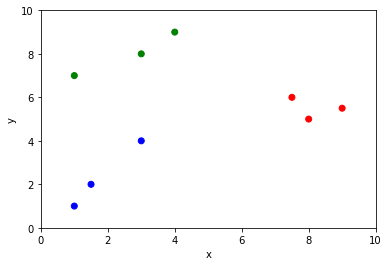

In [9]:
plt.scatter(df['X'], df['Y'], c=colors)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

----

In [18]:
kmeans = KMeans(n_clusters=3, n_iter=100, dist='cos')
kmeans.fit(df_X, drawing=False)
kmeans.labels

array([2, 2, 2, 1, 1, 2, 0, 0, 0])

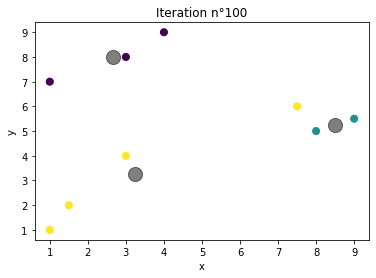

In [19]:
kmeans.graph

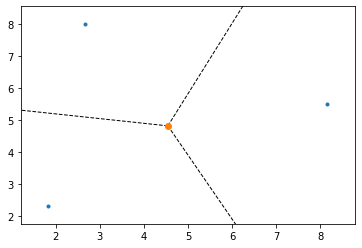

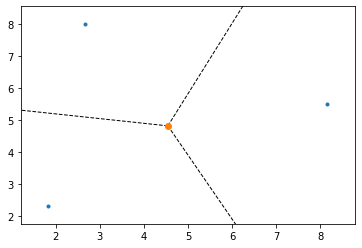

In [12]:


centers = kmeans.centroids
vor = Voronoi(centers)
voronoi_plot_2d(vor)

In [30]:
kmed = KMedoids(n_clusters=3, n_iter=100, dist='euc')
kmed.fit(df_X, drawing=False)
kmed.labels

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

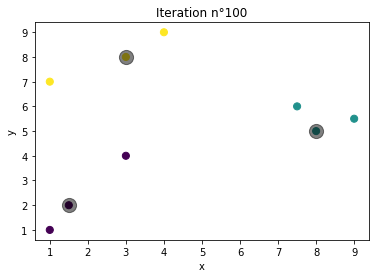

In [31]:
kmed.graph

----

## Test cas particulier - distance cos

In [32]:
p1 = Point([1, 2], 'b')
p2 = Point([3, 2], 'b')
p3 = Point([5, 2], 'b')
p4 = Point([7, 2], 'b')
p5 = Point([9, 2], 'b')

p6 = Point([1, 6], 'g')
p7 = Point([3, 6], 'g')
p8 = Point([5, 6], 'g')
p9 = Point([7, 6], 'g')
p10 = Point([9, 6], 'g')


L = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]

X = [p.x for p in L]
Y = [p.y for p in L]
colors = [p.color for p in L]
df = pd.DataFrame({'X':X, 'Y':Y, 'colors':colors})

df_X = df.loc[:,['X','Y']]

df;

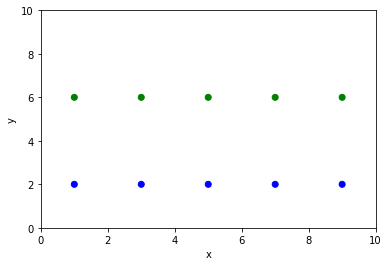

In [33]:
plt.scatter(df['X'], df['Y'], c=colors)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

In [36]:
kmeans = KMeans(n_clusters=2, n_iter=500, dist='cos')
kmeans.fit(df_X, drawing=False)
kmeans.labels

array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1])

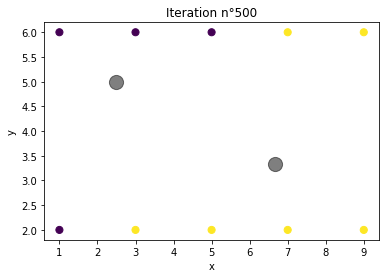

In [37]:
kmeans.graph

----

## Test cas particulier - distance L1

In [40]:
p1 = Point([1, 2])
p2 = Point([3, 2])
p3 = Point([5, 2])
p4 = Point([7, 2])

p5 = Point([1, 5])
p6 = Point([3, 5])
p7 = Point([5, 5])
p8 = Point([7, 5])

p9 = Point([1, 8])
p10 = Point([3, 8])
p11 = Point([5, 8])
p12 = Point([7, 8])


L = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12]

X = [p.x for p in L]
Y = [p.y for p in L]
colors = [p.color for p in L]
df = pd.DataFrame({'X':X, 'Y':Y, 'colors':colors})

df_X = df.loc[:,['X','Y']]

df;

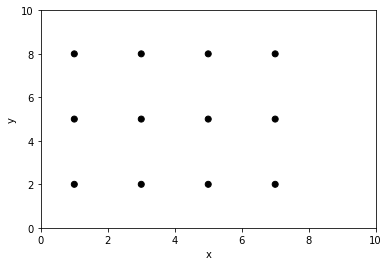

In [41]:
plt.scatter(df['X'], df['Y'], c=colors)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

In [46]:
kmeans = KMeans(n_clusters=2, n_iter=500, dist='l1')
kmeans.fit(df_X, drawing=False)
kmeans.labels

array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

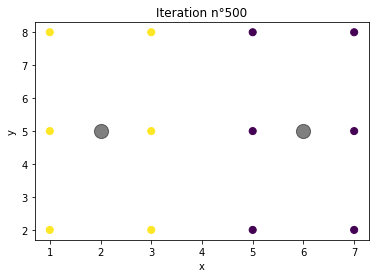

In [47]:
kmeans.graph

----

## Test nuage de points gaussien

### sigma_1 ~ sigma_2

Text(0, 0.5, '$x_2$')

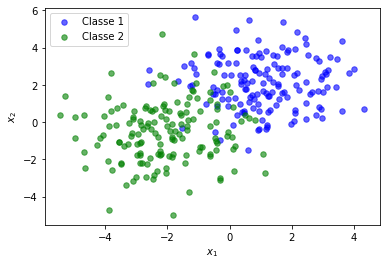

In [100]:
import scipy.stats as stats

c1 = stats.multivariate_normal(mean=[1.,2], cov=2)
c2 = stats.multivariate_normal(mean=[-2,-0.5], cov=2)

c1rvs = c1.rvs(size=150)  #composantes dans la classe 1
c2rvs = c2.rvs(size=150)

data = np.concatenate((c1rvs, c2rvs), axis=0)

x1_1 = c1rvs[:, 0]  #x1 dans la classe 1
x2_1 = c1rvs[:, 1]  #x2 dans la classe 1
x1_2 = c2rvs[:, 0]  #x1 dans la classe 2
x2_2 = c2rvs[:, 1]  #x2 dans la classe 2

# Graph
plt.scatter(x1_1, x2_1, marker='o', s=30, color='blue', alpha=0.6, label='Classe 1')
plt.scatter(x1_2, x2_2, s=30, color='green', alpha=0.6, label='Classe 2')
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

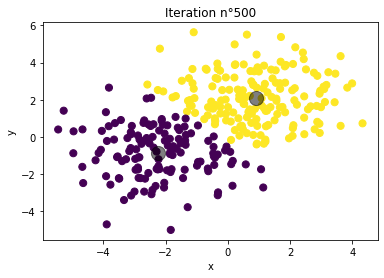

In [101]:
kmeans = KMeans(n_clusters=2, n_iter=500, dist='euc')
kmeans.fit(data, drawing=False)
kmeans.graph

----

### sigma_1 << sigma_2

Text(0, 0.5, '$x_2$')

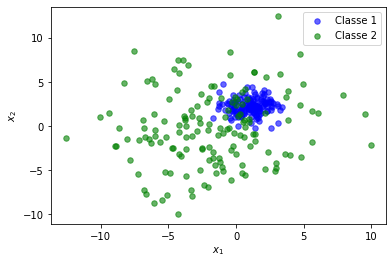

In [102]:
import scipy.stats as stats

c1 = stats.multivariate_normal(mean=[1.,2], cov=1)
c2 = stats.multivariate_normal(mean=[-2,-0.5], cov=15)

c1rvs = c1.rvs(size=150)  #composantes dans la classe 1
c2rvs = c2.rvs(size=150)

data = np.concatenate((c1rvs, c2rvs), axis=0)

x1_1 = c1rvs[:, 0]  #x1 dans la classe 1
x2_1 = c1rvs[:, 1]  #x2 dans la classe 1
x1_2 = c2rvs[:, 0]  #x1 dans la classe 2
x2_2 = c2rvs[:, 1]  #x2 dans la classe 2

# Graph
plt.scatter(x1_1, x2_1, marker='o', s=30, color='blue', alpha=0.6, label='Classe 1')
plt.scatter(x1_2, x2_2, s=30, color='green', alpha=0.6, label='Classe 2')
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

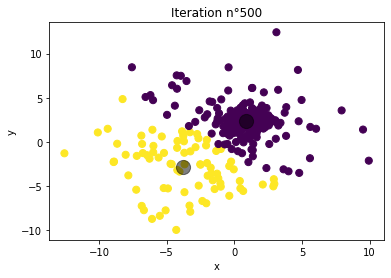

In [104]:
kmeans = KMeans(n_clusters=2, n_iter=500, dist='euc')
kmeans.fit(data, drawing=False)
kmeans.graph

In [229]:
'''
Ancienne (première) version de la classe KMeans, avant l'ajout des nouvelles distances *
A garder pour le rapport
'''

class KMeans:
    
    def __init__(self, n_clusters=2):
        self.K = n_clusters
        
    def fit(self, X, n_iter=10):
        """
        n_iter : int
                 Nombre d'itérations. 10 par défaut.
        """
        self.n_iter = n_iter
        self.centroids = np.array(X.iloc[np.random.choice(len(X), self.K, replace=False)])
        self.initial_centroids = self.centroids
        self.prev_label,  self.labels = None, np.zeros(len(X))
        for _ in range(self.n_iter):
            self.prev_label = self.labels
            self.labels = self.predict(X)
            self.update_centroid(X)
        return self
        
    def fit1(self, X):
        """
        On itère tant que les labels ne changent pas d'une itération à une autre.
        """
        self.centroids = np.array(X.iloc[np.random.choice(len(X), self.K, replace=False)])
        self.initial_centroids = self.centroids
        self.prev_label,  self.labels = None, np.zeros(len(X))
        while not np.all(self.labels == self.prev_label) :
            self.prev_label = self.labels
            self.labels = self.predict(X)
            self.update_centroid(X)
        return self
        
    def predict(self, X):
        return np.apply_along_axis(self.compute_label, 1, X)

    def compute_label(self, x):
        return self.euclidian_dist(x).argmin()
    
    def euclidian_dist(self, x):
        return np.sqrt(np.sum((x - self.centroids)**2, axis=1))

    def update_centroid(self, X):
        self.centroids = np.array([np.mean(X[self.labels == k], axis=0)  for k in range(self.K)])
        
kmeans = KMeans(3)